In [1]:
import json
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import optuna
import xgboost as xgb

# Load the JSON data
with open('descriptors.json', 'r') as file:
    data = json.load(file)

# Convert JSON data to a pandas DataFrame
# Each row will have 'formula', 'descriptors', and 'e_f' columns
formulas = []
descriptors = []
e_f_values = []


for formula, values in data.items():
    if values[1] < 10 and values[1] > -10:
        descriptors.append(values[0])  # Descriptor values
        e_f_values.append(values[1])    # e_f value
        formulas.append(formula)
    else:
        pass

# Create DataFrame
df = pd.DataFrame(descriptors)
df['e_f'] = e_f_values
df['formula'] = formulas

# Split the data into features (X) and target (y)
X = df.drop(columns=['e_f', 'formula'])  # All descriptor columns
y = df['e_f']                            # Target column

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [2]:
# Initialize and train the Random Forest Regressor
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    # Initialize and train the Random Forest Regressor with the suggested hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    r2 = r2_score(y_test, y_pred)
    
    # We want to maximize R-squared, so we return it directly
    return r2

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-11-07 00:48:04,770] A new study created in memory with name: no-name-6eb171cd-9ffb-4a9b-8e7f-4714336117b9
[I 2024-11-07 00:48:06,267] Trial 0 finished with value: 0.34358187328108947 and parameters: {'n_estimators': 244, 'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.34358187328108947.
[I 2024-11-07 00:48:07,516] Trial 1 finished with value: 0.32754228237313743 and parameters: {'n_estimators': 237, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.34358187328108947.
[I 2024-11-07 00:48:09,968] Trial 2 finished with value: 0.35146050220216696 and parameters: {'n_estimators': 375, 'max_depth': 42, 'min_samples_split': 13, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.35146050220216696.
[I 2024-11-07 00:48:11,946] Trial 3 finished with value: 0.3486875228766597 and parameters: {'n_estimators': 312, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 2 wit

Best hyperparameters: {'n_estimators': 136, 'max_depth': 33, 'min_samples_split': 10, 'min_samples_leaf': 4}


In [3]:
# Train the RandomForestRegressor with the best hyperparameters
best_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
best_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test_scaled)
y_pred_train = best_model.predict(X_train_scaled)

# Evaluate the optimized model
mse = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_train)

print("Optimized Mean Squared Error:", mse)
print("Optimized R-squared for the train:", r2_train)
print("Optimized R-squared for the test:", r2_test)

Optimized Mean Squared Error: 3.636254510320497
Optimized R-squared for the train: 0.6784646828386618
Optimized R-squared for the test: 0.35688460983742154


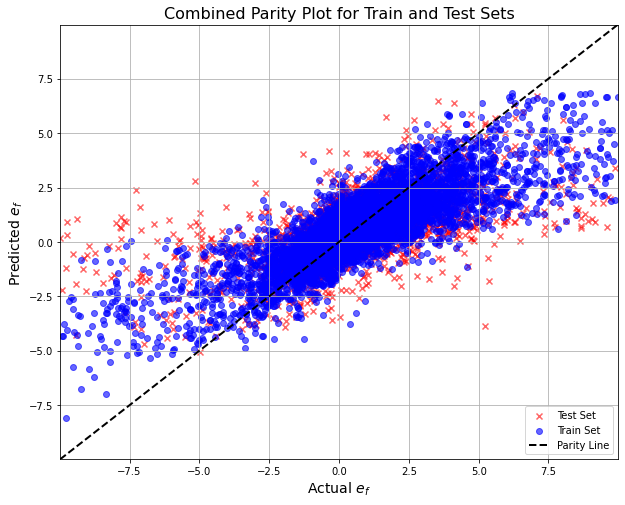

In [8]:
import matplotlib.pyplot as plt

# Combined parity plot for both train and test sets
plt.figure(figsize=(10, 8))

# Plot for test set in red
plt.scatter(y_test, y_pred, color='red', alpha=0.6, label="Test Set", marker='x')
# Plot for training set in blue
plt.scatter(y_train, y_pred_train, color='blue', alpha=0.6, label="Train Set", marker='o')

# 45-degree reference line (perfect prediction line)
min_val = min(y.min(), y_pred.min(), y_train.min(), y_pred_train.min())
max_val = max(y.max(), y_pred.max(), y_train.max(), y_pred_train.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label="Parity Line")

# Labels, title, and legend
plt.xlabel("Actual $e_f$", fontsize=14)
plt.ylabel("Predicted $e_f$", fontsize=14)
plt.title("Combined Parity Plot for Train and Test Sets", fontsize=16)
plt.legend(loc='lower right')
plt.grid(True)

# Improve the range for better plot visibility
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.show()


In [5]:
# XGBoost 

# Define the objective function for Optuna to optimize the XGBoost model
def objective(trial):
    # Suggest hyperparameters for XGBoost
    param = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0)
    }

    # Train the XGBoost model with the suggested hyperparameters
    model = xgb.XGBRegressor(**param, random_state=42, n_jobs=-1)
    model.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    r2 = r2_score(y_test, y_pred)
    
    return r2

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-11-07 00:59:20,153] A new study created in memory with name: no-name-05571b0d-e26c-4f53-bbf5-45624024d67e
[I 2024-11-07 00:59:29,901] Trial 0 finished with value: 0.27367625811785323 and parameters: {'n_estimators': 226, 'max_depth': 11, 'learning_rate': 0.059264574514853, 'subsample': 0.5866601853008531, 'colsample_bytree': 0.7977690416450907, 'reg_alpha': 1.5958934296769452e-07, 'reg_lambda': 1.9918952649207071e-07}. Best is trial 0 with value: 0.27367625811785323.
[I 2024-11-07 00:59:41,388] Trial 1 finished with value: 0.2626483225393873 and parameters: {'n_estimators': 61, 'max_depth': 12, 'learning_rate': 0.10856241925747881, 'subsample': 0.5569988096397889, 'colsample_bytree': 0.7896717851222961, 'reg_alpha': 5.373861439236193e-06, 'reg_lambda': 0.008971513919666217}. Best is trial 0 with value: 0.27367625811785323.
[I 2024-11-07 01:00:06,362] Trial 2 finished with value: 0.25079468407882466 and parameters: {'n_estimators': 221, 'max_depth': 14, 'learning_rate': 0.080390

Best hyperparameters: {'n_estimators': 407, 'max_depth': 6, 'learning_rate': 0.034081502366158825, 'subsample': 0.6657828407868014, 'colsample_bytree': 0.697622664252408, 'reg_alpha': 5.499813940325483e-05, 'reg_lambda': 0.9947036392554928}


In [6]:
best_model = xgb.XGBRegressor(**best_params, random_state=42, n_jobs=-1)
best_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test_scaled)
y_pred_train = best_model.predict(X_train_scaled)

# Evaluate the optimized model
mse = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_train)

print("Optimized Mean Squared Error:", mse)
print("Optimized R-squared for the train:", r2_train)
print("Optimized R-squared for the test:", r2_test)

Optimized Mean Squared Error: 3.623198118197211
Optimized R-squared for the train: 0.6455185091429789
Optimized R-squared for the test: 0.35919378998161966


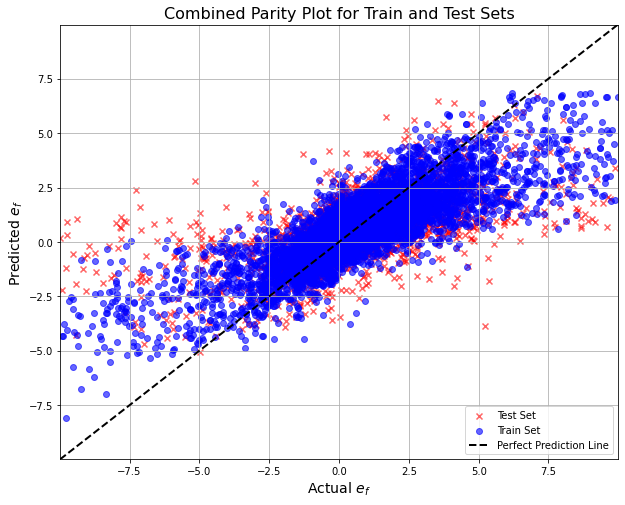

In [7]:
import matplotlib.pyplot as plt

# Combined parity plot for both train and test sets
plt.figure(figsize=(10, 8))

# Plot for test set in red
plt.scatter(y_test, y_pred, color='red', alpha=0.6, label="Test Set", marker='x')
# Plot for training set in blue
plt.scatter(y_train, y_pred_train, color='blue', alpha=0.6, label="Train Set", marker='o')

# 45-degree reference line (perfect prediction line)
min_val = min(y.min(), y_pred.min(), y_train.min(), y_pred_train.min())
max_val = max(y.max(), y_pred.max(), y_train.max(), y_pred_train.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label="Perfect Prediction Line")

# Labels, title, and legend
plt.xlabel("Actual $e_f$", fontsize=14)
plt.ylabel("Predicted $e_f$", fontsize=14)
plt.title("Combined Parity Plot for Train and Test Sets", fontsize=16)
plt.legend(loc='lower right')
plt.grid(True)

# Improve the range for better plot visibility
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.show()
